## Use openAI blackjack as example

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import sys
import gym
sys.path.append("../") 
from rl.plotting import plot_blackjack_value_function

## let use get familar with black jack env

In [2]:
env = gym.make('Blackjack-v0')
env.reset()

(13, 10, False)

In [3]:
def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print(f"Player Score: {score} (Usable Ace: {usable_ace}), Dealer Score: {dealer_score}")

def strategy(observation):
    score, dealer_score, usable_ace = observation
    # Stick (action 0) if the score is > 20, hit (action 1) otherwise
    return 0 if score >= 18 else 1

action_space=["Stick", "Hit"]

for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        print_observation(observation)
        action = strategy(observation)
        print("Taking action: {action_space[action]}")
        observation, reward, done, _ = env.step(action)
        if done:
            print_observation(observation)
            print(f"#End Reward: {reward}\n")
            break

Player Score: 12 (Usable Ace: False), Dealer Score: 2
Taking action: {action_space[action]}
Player Score: 19 (Usable Ace: False), Dealer Score: 2
Taking action: {action_space[action]}
Player Score: 19 (Usable Ace: False), Dealer Score: 2
#End Reward: 1.0

Player Score: 18 (Usable Ace: False), Dealer Score: 1
Taking action: {action_space[action]}
Player Score: 18 (Usable Ace: False), Dealer Score: 1
#End Reward: 1.0

Player Score: 14 (Usable Ace: True), Dealer Score: 1
Taking action: {action_space[action]}
Player Score: 13 (Usable Ace: False), Dealer Score: 1
Taking action: {action_space[action]}
Player Score: 23 (Usable Ace: False), Dealer Score: 1
#End Reward: -1

Player Score: 18 (Usable Ace: False), Dealer Score: 4
Taking action: {action_space[action]}
Player Score: 18 (Usable Ace: False), Dealer Score: 4
#End Reward: -1.0

Player Score: 18 (Usable Ace: False), Dealer Score: 10
Taking action: {action_space[action]}
Player Score: 18 (Usable Ace: False), Dealer Score: 10
#End Reward: 

## Policy Iteration With Monte-Carlo Evaluation
* Policy evaluation V(S) $\rightarrow$ Q(s,a)

We can not use V, since we want to derive policy in model free, knowing V only will need to know the MDP S-->S' to derive policy, but Q(s,a) can give us policy directly.

* Policy improvement Greedy $\rightarrow$ $\epsilon$-greedy

Instead of using greedy, using $\epsilon$-greedy can make sure we explore all possible state action pairs, if we explore enough episode.

## $\epsilon$-Greedy Exploration
$$
\pi(a|s)=\left\{
\begin{array}{lcl}
\frac{\epsilon}{m} & &  otherwise \\
\frac{\epsilon}{m} + 1 -\epsilon & &  if a^*=argmaxQ(s,a)
\end{array}
\right.
$$



## GLIE Monte-Carlo Control

After $k$th episode $S_1$, $A_1$, $R_2$, ... , $S_T$
* Policy Evaluation
    * $N(S_t) \leftarrow N(S_t) + 1$
    * $Q(S_t,A_t) \leftarrow Q(S_t, A_t) + \frac{1}{N(S_t,A_t)}(G_t-Q(S_t,A_t))$
    Where $G_t=R_{t+1} + \gamma R_{t+2} + ... + \gamma^{T−1}_{R_T}$
* Policy Improvement
    * $\epsilon = \frac{1}{k}$
    * $\pi = \epsilon$-greedy

In [4]:
def create_epsilon_greedy_policy(Q):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation , k):
        epsilon=min(1/k,1)
        A_value=Q[observation]
        m=len(A_value)
        A_prob = np.ones_like(A_value)*epsilon/m
        A_prob[np.argmax(A_value)] += (1.0 - epsilon)
        return A_prob
    return policy_fn

In [5]:
def glie_mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (list of action-value where action is the position ).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = create_epsilon_greedy_policy(Q)
    
    for i_episode in tqdm(range(num_episodes)):

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode_states = []
        episode_actions = []
        episode_rewards = []
        current_state = env.reset()
        done = False
        while not done:
            probs = policy(current_state, i_episode+1)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode_states.append(current_state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            if done:
                break
            current_state = next_state

        # iteration through (state, action) pairs we've visited in this episode
        for t, (state, action) in enumerate(zip(episode_states,episode_actions)):
            sa_pair = (state, action)
            G = sum([x*(discount_factor**i) for i,x in enumerate(episode_rewards[t:])])
            #print(G_t)
            returns_count[sa_pair] += 1
            Q[state][action] += (1.0/returns_count[sa_pair])*(G-Q[state][action])
        
        # The policy is improved implicitly by changing the Q dictionary
    #clear some trivial states for better visualization       
    states = set(Q.keys())
    for s in states:
        if s[0]>21 or s[0]<12:
            del Q[s]    
    # by picking the best action at each state
    V = defaultdict(float)
    for state, actions in Q.items():
        action_value = np.max(actions)
        V[state] = action_value
    return Q, V, policy

In [6]:
num_episodes=500000
Q, V, policy = glie_mc_control_epsilon_greedy(env, num_episodes=num_episodes)

100%|██████████| 1000000/1000000 [02:11<00:00, 7625.18it/s]


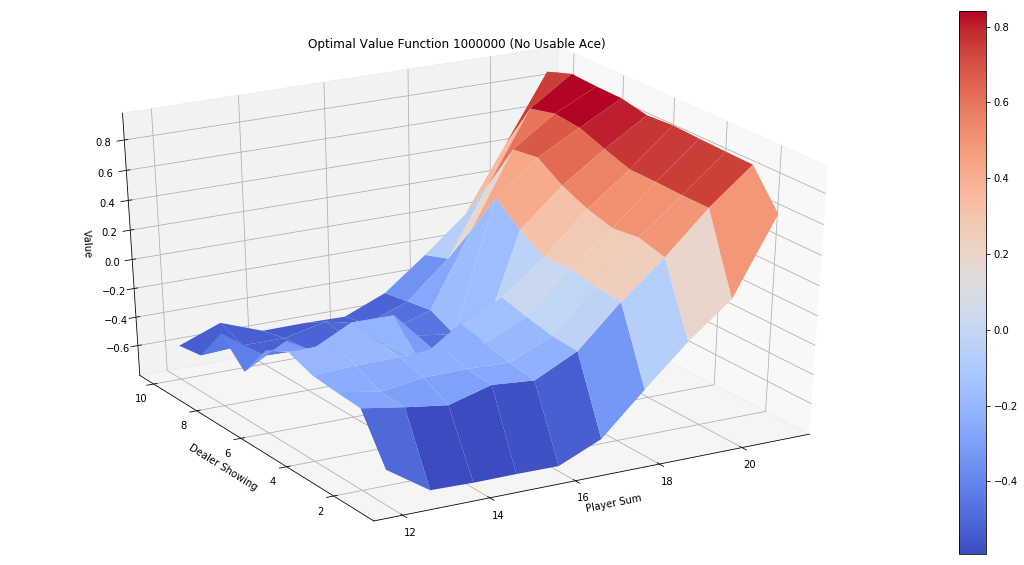

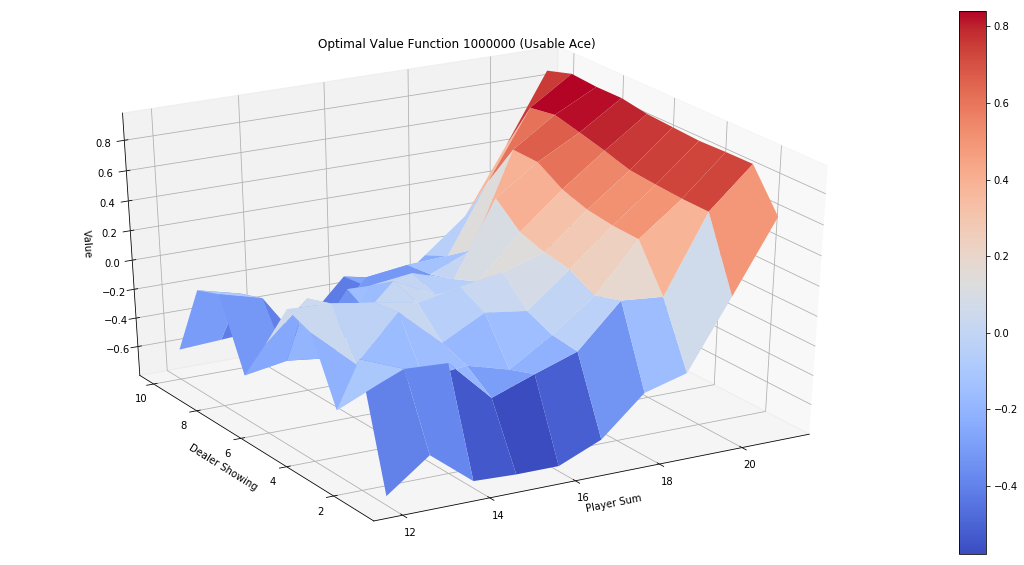

In [7]:
# For plotting: Create value function from action-value function
plot_blackjack_value_function(V, title=f"Optimal Value Function {num_episodes}")

## TD Control ==> SARSA

In [ ]:
def glie_sarsa_control_epsilon_greedy(env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (list of action-value where action is the position ).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = create_epsilon_greedy_policy(Q)
    
    for i_episode in tqdm(range(num_episodes)):

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode_states = []
        episode_actions = []
        episode_rewards = []
        current_state = env.reset()
        done = False
        while not done:
            probs = policy(current_state, i_episode+1)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode_states.append(current_state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            if done:
                break
            current_state = next_state

        # iteration through (state, action) pairs we've visited in this episode
        for t, (state, action) in enumerate(zip(episode_states,episode_actions)):
            sa_pair = (state, action)
            G = sum([x*(discount_factor**i) for i,x in enumerate(episode_rewards[t:])])
            #print(G_t)
            returns_count[sa_pair] += 1
            Q[state][action] += (1.0/returns_count[sa_pair])*(G-Q[state][action])
        
        # The policy is improved implicitly by changing the Q dictionary
    #clear some trivial states for better visualization       
    states = set(Q.keys())
    for s in states:
        if s[0]>21 or s[0]<12:
            del Q[s]    
    # by picking the best action at each state
    V = defaultdict(float)
    for state, actions in Q.items():
        action_value = np.max(actions)
        V[state] = action_value
    return Q, V, policy